In [1]:
from VAE import VAE
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
from torchvision.datasets import CelebA
import matplotlib.pyplot as plt
import einops
from tqdm import tqdm
import math
from utils import display_img

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class MyCelebADataset(Dataset):
    def __init__(self, images_dir, attributes_file, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        
        # Read the attributes file
        with open(attributes_file, "r") as f:
            lines = f.readlines()
        
        self.attr_names = lines[1].strip().split()  # list of attribute names
        self.data = []
        for line in lines[2:]:  # skip first two lines
            parts = line.strip().split()
            filename = parts[0]
            attrs = list(map(int, parts[1:]))
            self.data.append((filename, attrs))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        filename, attrs = self.data[idx]
        img_path = os.path.join(self.images_dir, filename)
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        attrs = torch.tensor(attrs, dtype=torch.float32)
        
        return image, attrs

In [3]:
transform = transforms.Compose([
    transforms.CenterCrop(178),     # Crop to 178x178 (centered)
    transforms.Resize(64),          # Then resize to 64x64
    transforms.ToTensor(),          # Convert to tensor (scales pixel values to [0,1])
])

dataset = MyCelebADataset(
    images_dir="/Users/spra/Desktop/Personal Projects/CelebA/celeba/img_align_celeba",
    attributes_file="/Users/spra/Desktop/Personal Projects/CelebA/celeba/list_attr_celeba.txt",
    transform=transform
)

dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [4]:
model = VAE(device = 'mps', in_channels = 3, latent_dim = 128)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [5]:
def train(loader, model, optimizer):
    model = model.to(model.device)
    losses = []
    for batch in tqdm(loader):
        images, atributes = batch[0], batch[1]
        images = images.to(model.device)
        reconstructions, mu, logvar = model(images)
        loss = model.loss_function(images, reconstructions, mu, logvar)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
    print(f'Average loss: {sum(losses)/len(losses)}')
    return losses

In [6]:
num_epochs = 10
all_losses = []
for i in range(num_epochs):
    print(f'Starting epoch: {i}')
    losses = train(dataloader, model, optimizer)
    all_losses.extend(losses)

Starting epoch: 0


100%|██████████| 1583/1583 [02:15<00:00, 11.66it/s]


Average loss: 0.040226998152381926
Starting epoch: 1


100%|██████████| 1583/1583 [02:15<00:00, 11.72it/s]


Average loss: 0.03338546385083745
Starting epoch: 2


 61%|██████    | 963/1583 [01:19<00:51, 12.09it/s]


KeyboardInterrupt: 

In [16]:
torch.save(model.state_dict(), 'ten_epochs.pt')

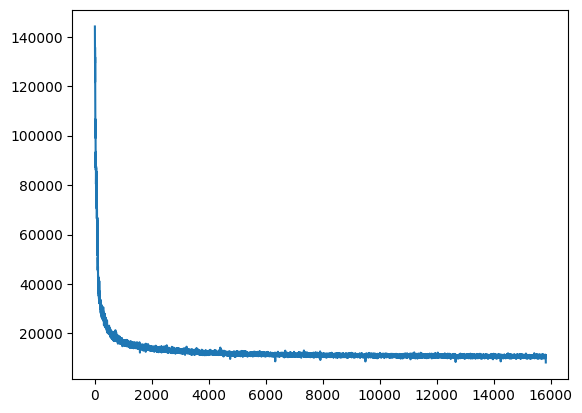

In [17]:
plt.plot(all_losses)

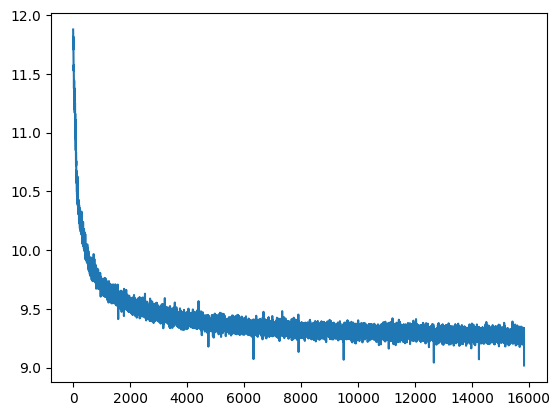

In [18]:
log_losses = torch.log(torch.tensor(all_losses)).cpu().numpy()
plt.plot(log_losses)

In [19]:
def display_img(img, h, w):
    reshaped = einops.rearrange(img, 'b c h w -> b h w c').cpu().numpy()
    fig, ax = plt.subplots(h, w, figsize=(10, 10))
    for i in range(h):
        for j in range(w):
            to_show = reshaped[h * i + j]
            ax[i, j].imshow(to_show)
            ax[i, j].axis('off')

In [20]:
batch = next(iter(dataloader))

In [21]:
def reconstruct(model, batch):
    batch = batch[0].to(device)
    with torch.no_grad():
        reconstructions, mu, logvar = model(batch)
    return reconstructions

In [22]:
reconstructions = reconstruct(model, batch)

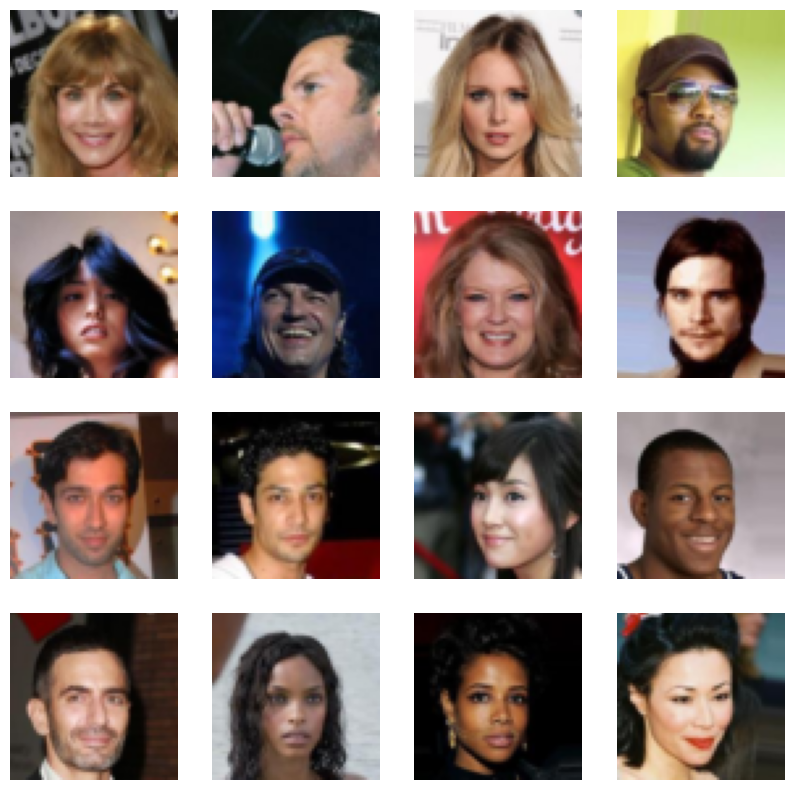

In [23]:
display_img(batch[0], 4, 4)

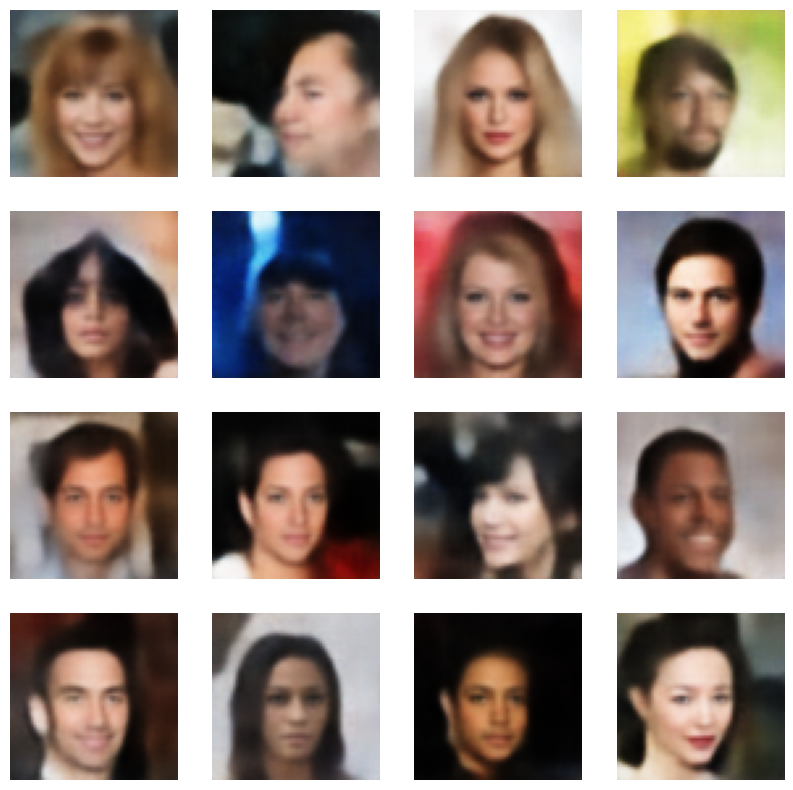

In [24]:
display_img(reconstructions, 4, 4)